# Maximum Entropy Matching Distribution Function

This notebook can construct the distribution function which maximizes the kinetic entropy subject to the constraints of matching the energy density $\epsilon$ and the total isotropic pressure $P \equiv p + \Pi$.

The entropy density current is expressed

$$s^{\mu}(x) = - \sum_h \frac{g_h}{(2\pi)^3}\int \frac{d^3p}{p_0} p^{\mu} \phi[f_h],$$

where $h$ runs over all hadronic species, $g_h$ is the degeneracy of species $h$, and $f_h(x;p)$ is the distribution function of particles of species $h$.

The function $\phi[f_h]$ defined by

$$ \phi[f] \equiv f \ln (f) - \frac{1 + \theta f}{\theta} \ln(1 + \theta f)$$

defines the quantum statistical nature of the particles, with $\theta = 1$, $0$ or $-1$ for bosons, Maxwell-Boltzmann particles, and fermions respectively.

In [1]:
%load_ext Cython
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
import pandas as pd
sns.set()
sns.set_style('whitegrid')
sns.set_context('talk')

## The cell below constructs the grid of energy density and pressure
It takes a while to run. Unless we need to change the particle/grid options, we can just load the grid from disk.
If you want to change the grid limits, discretization, or change the Hadron Resonances Gas, it needs to be rerun.
To do this, set `recalculate_grids = True`.

The particle information is loaded from the PDG particle data table using functions defined here: https://github.com/Duke-QCD/frzout. The particles included in the Hadron Resonance Gas are those which can be propagated by UrQMD. 

In [2]:
%%cython 
import numpy as np
cimport numpy as np
from scipy import integrate
import time
from libc.math cimport exp
from libc.math cimport sqrt
from libc.math cimport fabs
from libc.math cimport fmin
from libc.math cimport copysignf

DTYPE = np.float
ctypedef np.float_t DTYPE_t

### physical constants
cpdef float hbar = 0.197
cpdef float hbar3 = hbar*hbar*hbar

from species import species_dict, _normalize_species, urqmd
species = _normalize_species(species='all')
#the sign \theta defining BE or FD statistics
for pid in species:
    pid[1]['sign'] = 1. if pid[1]['boson'] else -1.
n_species = len(species)

############################
########USER OPTIONS########
#particles included in thermodynamic quantities
chosen_particles = species_dict.keys()

#Grid parameters
cdef int npts_beta = 200 #size of grid in beta (effective temperature)
cdef int npts_rho = 250  #size of grid in rho  (controls bulk pressure)

cdef float T_eff_max = 0.20 #max. eff. temperature in GeV
cdef float T_eff_min = 0.05 #min. eff. temperature in GeV

#|lambda| <= |beta|
#so define rho by lambda = rho * beta, with rho in [-1, 1]
cdef float rho_min = -0.9
cdef float rho_max = 0.9
############################
########USER OPTIONS########

cdef float beta_min = 1. / T_eff_max #GeV^-1
cdef float beta_max = 1. / T_eff_min #GeV^-1
#grid of values of beta and rho for which we calculate the 
#energy density and total isotropic pressure
beta_grid = np.linspace(beta_min, beta_max, npts_beta)
rho_grid = np.linspace(rho_min, rho_max, npts_rho)

# The maximal-entropy distribution function
cpdef float f_dist(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, lambdapi, arg
    E2 = E*E
    m2 = m*m
    lambdapi = rho*beta
    arg = E * ( beta + lambdapi*(1. - m2/E2) )
    return 1./(exp(arg) - sign)

# The local equil. distribution function
cpdef float f_eq(float E, float beta_eq, float sign):
    cdef float arg
    arg = beta_eq * E
    return 1./(exp(arg) - sign)

# The linear CE RTA distribution
cpdef float f_CE_lin(float E, float beta_eq, float bulk_Pi, 
                     float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, f0, f_fbar, a, b, df, f
    E2 = E*E
    m2 = m*m
    f0 = f_eq(E, beta_eq, sign)
    f_fbar = f0 * (1. + sign*f0)
    a = beta_eq * beta_eq * F * E
    b = beta_eq * (E2 - m2) / 3. / E #is this sign right????
    df = f_fbar * bulk_Pi * (a + b) / beta_Pi
    #need to do regulation if moments are well-defined
    #df = copysignf( fmin(fabs(df), f0), df )
    f = f0 + df
    return f

#the integrand for computing the energy density
cpdef float eps_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E2 * sqrt(E2 - m2) * f_dist(E, beta, rho, m, sign)

#computes the energy density given the Lagrange multipliers
cpdef float eps(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(eps_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#the integrand for the total isotropic pressure p+Pi
cpdef float P_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3 / 3.
    return num_factor * (E2 - m2)**(1.5) * f_dist(E, beta, rho, m, sign)

#computes the total isotropic pressure p+Pi
cpdef float P(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(P_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#the particle density integrand
cpdef float n_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * sqrt(E2 - m2) * f_dist(E, beta, rho, m, sign)

#computes the particle density
cpdef float n(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(n_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#the mean |p| integrand
cpdef float mean_p_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * (E2 - m2) * f_dist(E, beta, rho, m, sign)

#computes the mean |p|
cpdef float mean_p(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(mean_p_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#particle density integrand for the linear CE RTA dist.
cpdef float n_integrand_CE(float E, float beta_eq, float bulk_Pi, 
                            float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * sqrt(E2 - m2) * f_CE_lin(E, beta_eq, bulk_Pi, 
                                                     beta_Pi, F, m, sign)
#particle density for linear CE RTA
cpdef float n_CE(float beta_eq, float bulk_Pi, float beta_Pi, float F, 
                 float m, float sign):
    cdef float val, err
    val, err = integrate.quad(n_integrand_CE, m, np.inf, args=(beta_eq, bulk_Pi, 
                            beta_Pi, F, m, sign))
    return val

#mean |p| integrand for the linear CE RTA dist.
cpdef float mean_p_integrand_CE(float E, float beta_eq, float bulk_Pi, 
                            float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * (E2 - m2) * f_CE_lin(E, beta_eq, bulk_Pi, 
                                                     beta_Pi, F, m, sign)
#mean |p| for linear CE RTA
cpdef float mean_p_CE(float beta_eq, float bulk_Pi, float beta_Pi, float F, 
                 float m, float sign):
    cdef float val, err
    
    val, err = integrate.quad(mean_p_integrand_CE, m, np.inf, args=(beta_eq, bulk_Pi, 
                            beta_Pi, F, m, sign))
    return val


#the integrand for the total isotropic pressure p+Pi for CE RTA
cpdef float P_integrand_CE(float E, float beta_eq, float bulk_Pi, float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3 / 3.
    return num_factor * (E2 - m2)**(1.5) * f_CE_lin(E, beta_eq, bulk_Pi, beta_Pi, F, m, sign)

#computes the total isotropic pressure p+Pi for CE RTA
cpdef float P_CE(float beta_eq, float bulk_Pi, float beta_Pi, float F, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(P_integrand_CE, m, np.inf, args=(beta_eq, bulk_Pi, beta_Pi, F, m, sign))
    return val

#If any options related to the (beta,rho) grid or HRG are changed, 
#the grids need to be recalculated
recalculate_grids = False

cdef np.ndarray eps_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray P_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray eq_eps_grid = np.zeros(npts_beta, dtype=DTYPE)
cdef np.ndarray eq_p_grid = np.zeros(npts_beta, dtype=DTYPE)

cdef float m, sign, degen, has_anti
cdef float beta, rho
cdef int ibeta, irho

t1 = time.time()
if recalculate_grids:
                
    for k in range(n_species): #sum over species
        particle = species[k]
        pid = particle[0]
        particle_dict = particle[1]
        m = particle_dict['mass'] #mass
        sign = particle_dict['sign'] #BE or FD sign
        degen = particle_dict['degen'] #spin degeneracy
        prefac = degen
        
        for ibeta, beta in enumerate(beta_grid):
            eq_eps_grid[ibeta] += prefac * eps(beta, 0.0, m, sign) 
            eq_p_grid[ibeta] += prefac * P(beta, 0.0, m, sign)
            
            for irho, rho in enumerate(rho_grid):
                eps_grid[ibeta, irho] += prefac * eps(beta, rho, m, sign)
                P_grid[ibeta, irho]   += prefac * P(beta, rho, m, sign)
    #save the grids to disk, so they can be loaded next time
    np.savetxt("grids/eps.dat", eps_grid)
    np.savetxt("grids/P.dat", P_grid)
    np.savetxt("grids/eq_eps.dat", eq_eps_grid)
    np.savetxt("grids/eq_p.dat", eq_p_grid)
    
    
#define functions to calculate the equil. pressure
#and total isotropic pressure to test reconstruction accuracy
cpdef calc_equil_pressure(float beta_eq):
    cdef float p0 = 0.
    for k in range(n_species): #sum over species
        particle = species[k]
        pid = particle[0]
        particle_dict = particle[1]
        m = particle_dict['mass'] #mass
        sign = particle_dict['sign'] #BE or FD sign
        degen = particle_dict['degen'] #spin degeneracy
        prefac = degen
        
        p0 += prefac * P(beta_eq, 0.0, m, sign)
    return p0

cpdef calc_tot_isotropic_pressure_CE(float beta_eq, float bulk_Pi, float beta_Pi, float F):
    cdef float p0 = 0.
    for k in range(n_species): #sum over species
        particle = species[k]
        pid = particle[0]
        particle_dict = particle[1]
        m = particle_dict['mass'] #mass
        sign = particle_dict['sign'] #BE or FD sign
        degen = particle_dict['degen'] #spin degeneracy
        prefac = degen
        p0 += prefac * P_CE(beta_eq, bulk_Pi, beta_Pi, F, m, sign)
    return p0

t2 = time.time()

/Users/derek/miniconda3/lib/python3.6/imp.py:343: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return _load(spec)
/Users/derek/miniconda3/lib/python3.6/imp.py:343: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return _load(spec)


In [3]:
print("Time elapsed : " + str(t2-t1) + " sec")

Time elapsed : 1425.0386259555817 sec


### Load the pre-calculated grids and coefficients from disk

In [4]:
#load the pre-calculated grid from disk
eps_grid = np.loadtxt("grids/eps.dat")
P_grid = np.loadtxt("grids/P.dat")
eq_eps_grid = np.loadtxt("grids/eq_eps.dat")
eq_p_grid = np.loadtxt("grids/eq_p.dat")

In [5]:
#load the tables from iS3D for Linear Chapman-Enskog RTA bulk coeffs
beta_Pi_df = pd.read_csv('grids/iS3D_tables/urqmd/betabulk.dat', sep='  ')
F_df = pd.read_csv('grids/iS3D_tables/urqmd/F.dat', sep='  ')

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#Units in tables according to M. McNelis
beta_Pi_df['beta_Pi[GeV/fm^3]'] = beta_Pi_df['betabulk_over_T4[GeV^-1fm^-3]'] * (beta_Pi_df['T[GeV]']**4. )
beta_Pi_df['beta[GeV^-1]'] = 1. / beta_Pi_df['T[GeV]']
F_df['F[GeV]'] = F_df['F_over_T'] * F_df['T[GeV]']
F_df['beta[GeV^-1]'] = 1. / F_df['T[GeV]']

### Plotting the energy density, total pressure and equilibrium EoS 

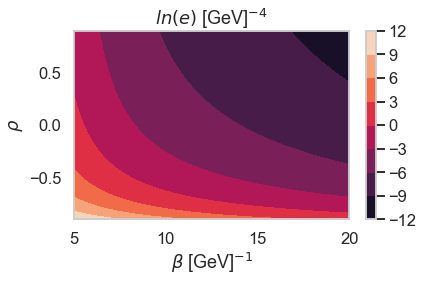

In [7]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
plt.contourf(xx, yy, np.log(eps_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(e)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

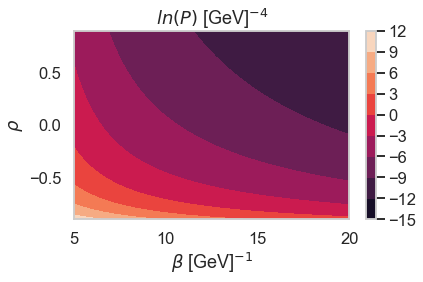

In [8]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
plt.contourf(xx, yy, np.log(P_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(P)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

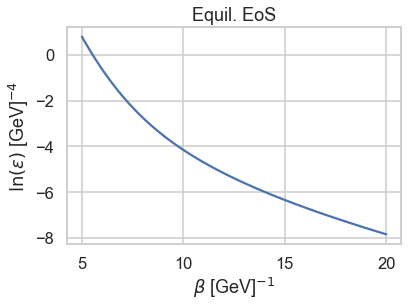

In [9]:
plt.plot(beta_grid, np.log(eq_eps_grid) )
plt.xlabel(r'$\beta$ [GeV]$^{-1}$')
plt.ylabel(r'$\ln(\epsilon)$ [GeV]$^{-4}$')
plt.title(r'Equil. EoS')
plt.show()

### Now we will create interpolations of the grid. 
This will allow us to invert the relations
$$\epsilon = \epsilon(\beta, \rho)$$
$$P = P(\beta, \rho)$$

into 

$$\beta = \beta(\epsilon, P)$$
$$\rho = \rho(\epsilon, P).$$

Once we have the interpolations $\epsilon = \epsilon(\beta, \rho)$ and $P = P(\beta, \rho)$, these can be inverted simultaneously by a two-dimensional root-finding routine.
The Andersen method in the `SciPy` implementation has done fairly well for our tests.

In a real phenomenological setting, each cell on the particlization surface may have a different isotropic pressure, and perhaps a different energy density. In this case, the interpolations can be loaded and reused together with the root finding method to find the Lagrange multipliers $\beta$ and $\rho$ for each cell.

In [10]:
#creating interpolations of the energy density e(beta, lambda) 
#and total pressure P(beta, lambda)
ln_eps_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(eps_grid) )
ln_P_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(P_grid) )

ln_eq_eps_interp = interpolate.interp1d(np.log(eq_eps_grid), beta_grid )
ln_eq_eps_given_beta_interp = interpolate.interp1d(beta_grid, np.log(eq_eps_grid) )

ln_eq_p_interp = interpolate.interp1d(beta_grid, np.log(eq_p_grid) )
#ln_eq_beta_Pi_interp = interpolate.interp1d(beta_grid, np.log(eq_beta_Pi_grid) )

#careful beta_Pi < 0
ln_beta_Pi_interp = interpolate.interp1d(beta_Pi_df['beta[GeV^-1]'], np.log(beta_Pi_df['beta_Pi[GeV/fm^3]']) )
F_interp = interpolate.interp1d(F_df['beta[GeV^-1]'],  F_df['F[GeV]'] )

In [11]:
##FOR TESTING ROOT SOLVING
#true values of beta and rho
#beta_true = 6.
#rho_true = 0.5
#the values of energy density and total pressure are given
#ln_e0 = ln_eps_interp(beta_true, rho_true).flatten()[0] 
#ln_P0 = ln_P_interp(beta_true, rho_true).flatten()[0] 
##FOR TESTING ROOT SOLVING

### Plotting the distributions

In [12]:
T_sw = 0.15 #typical switching temperature in GeV
beta_sw = 1./ T_sw

ln_e0 = ln_eq_eps_given_beta_interp(beta_sw) #energy density e = e(T_sw) of HRG
p_sw = np.exp( ln_eq_p_interp(beta_sw) ) #equilibrium pressure p=p(T_sw) of HRG
bulk_Pi_sw = -1.* p_sw / 3. #choose a value of the bulk pressure 
#bulk_Pi_sw = 0.
P0_sw = p_sw + bulk_Pi_sw #total isotropic pressure
ln_P0 = np.log(P0_sw)

beta_Pi0 = np.exp(ln_beta_Pi_interp(beta_sw)) #beta_Pi for CE RTA
F0 = F_interp(beta_sw) #F for CE RTA

print("ln_e0 = " + str(ln_e0) + ", ln_P0 = " + str(ln_P0))

ln_e0 = -1.440587498461369, ln_P0 = -3.6049453379722456


In [13]:
def root_solve_beta_rho(ln_e0, ln_p0, guess, tol=1e-7, maxiter = int(1e5)):
    """Find the solution (beta, rho) which matches both the given
    energy density and total isotr. pressure"""
    
    def my_fun(x):
        """input is vector with x[0] = beta, x[1] = rho"""
        ln_eps_func = ln_eps_interp(x[0], x[1]).flatten()[0] 
        ln_P_func = ln_P_interp(x[0], x[1]).flatten()[0] 
        return [ln_eps_func - ln_e0, ln_P_func - ln_P0]
    
    def print_warning(ln_e0, ln_P0):
        print("WARNING - NO ROOT FOUND: ln_e0 = " + str(ln_E0) + " ; ln_P0 = " + str(ln_P0))
        
    solution = optimize.root(my_fun, guess, method='anderson', 
                             tol=tol, options={'maxiter':maxiter})
    if (solution.success == False):
        print_warning(ln_e0, ln_P0)
        
    beta_soln = solution.x[0]
    rho_soln = solution.x[1]
    return beta_soln, rho_soln, solution

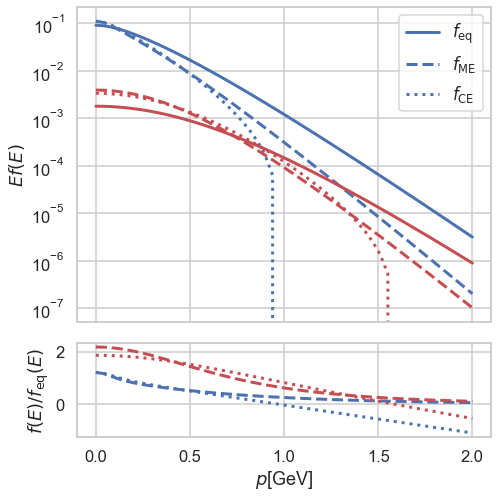

In [14]:
beta_soln, rho_soln, info = root_solve_beta_rho(ln_e0, ln_P0, [7.0, 0.]) 

#now plot these functions
pid_plot = [211, 2212]
pid_color = {211: 'b', 2212: 'r'}
heights = [1., 0.3]
p_grid = np.linspace(0., 2., 50) #momenta |p| in GeV in LRF

fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True, 
                         gridspec_kw={'height_ratios': heights})
axes[0].semilogy()

for ipid, pid in enumerate(pid_plot):
    m  = species_dict[pid]['mass']
    sign  = species_dict[pid]['sign']
    degen = species_dict[pid]['degen']
     
    if ipid == 0:
        label_ME = r'$f_{\rm ME}$'
        label_eq = r'$f_{\rm eq}$'
        label_CE = r'$f_{\rm CE}$'
    else:
        label_ME = label_eq = label_CE = None
    
    f_ME_vals = np.array([np.sqrt(p*p + m*m)*f_dist(np.sqrt(p*p + m*m), 
                    beta_soln, rho_soln, m, sign) for p in p_grid])
    f_eq_vals = np.array([np.sqrt(p*p + m*m)*f_eq(np.sqrt(p*p + m*m), 
                                                  beta_sw, sign) for p in p_grid])
    f_CE_vals = np.array([np.sqrt(p*p + m*m)*f_CE_lin(np.sqrt(p*p + m*m), beta_sw, bulk_Pi_sw, 
                         beta_Pi0, F0, m, sign) for p in p_grid])
    
    ratio_ME = f_ME_vals / f_eq_vals
    ratio_CE = f_CE_vals / f_eq_vals
    
    axes[0].plot(p_grid, f_eq_vals, lw=3, label=label_eq, ls='-', color=pid_color[pid])
    axes[0].plot(p_grid, f_ME_vals, lw=3, label=label_ME, ls='--', color=pid_color[pid])
    axes[0].plot(p_grid, f_CE_vals, lw=3, label=label_CE, 
             ls=':', color=pid_color[pid])
    
    axes[1].plot(p_grid, ratio_ME, lw=3, label=label_ME, ls='--', color=pid_color[pid])
    axes[1].plot(p_grid, ratio_CE, lw=3, label=label_CE, ls=':', color=pid_color[pid])

axes[1].set_xlabel(r'$p$[GeV]')
axes[0].set_ylabel(r'$E f(E)$')
axes[1].set_ylabel(r'$f(E)/f_{\rm eq}(E)$')
axes[0].legend()
plt.tight_layout(True)
plt.subplots_adjust(hspace=0.1)
plt.savefig('plots/spectra.png', dpi=400)
plt.show()

In [15]:
#let's compute the particle densities as a function of bulk pressure
first_guess = [7.0, 0.]
guess = first_guess

n_CE_ratio = {}
n_ME_ratio = {}

mean_p_ME_ratio = {}
mean_p_CE_ratio = {}

R_Pi_grid = np.linspace(0., 0.5, 50)

for ipid, pid in enumerate(pid_plot):
    m  = species_dict[pid]['mass']
    sign  = species_dict[pid]['sign']
    degen = species_dict[pid]['degen']
    
    #densities
    n_CE_arr = []
    n_ME_arr = []
    #mean |p|
    mean_p_ME_arr = []
    mean_p_CE_arr = []
    
    n_eq0 = n(beta_sw, 0., m, sign)
    mean_p_eq0 = mean_p(beta_sw, 0., m, sign)
    
    for R_Pi_inv in R_Pi_grid:
        bulk_Pi_sw = -R_Pi_inv * p_sw 
        P0_sw = p_sw + bulk_Pi_sw
        ln_P0 = np.log(P0_sw)
    
        beta_soln, rho_soln, info = root_solve_beta_rho(ln_e0, ln_P0, guess)
        #update guess for next step
        guess = [beta_soln, rho_soln]
        
        n_ME_arr.append( n(beta_soln, rho_soln, m, sign) / n_eq0 )
        n_CE_arr.append( n_CE(beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign) / n_eq0 )
           
        mean_p_ME_arr.append( mean_p(beta_soln, rho_soln, m, sign) / mean_p_eq0)
        mean_p_CE_arr.append( mean_p_CE(beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign) / mean_p_eq0 )
        
    n_ME_ratio[pid] = n_ME_arr
    n_CE_ratio[pid] = n_CE_arr
    
    mean_p_ME_ratio[pid] = mean_p_ME_arr
    mean_p_CE_ratio[pid] = mean_p_CE_arr

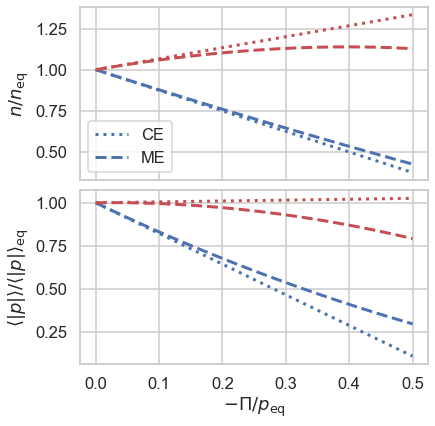

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for ipid, pid in enumerate(pid_plot):
    if ipid == 0:
        label_CE = 'CE'
        label_ME = 'ME'
    else:
        label_CE = label_ME = None
    axes[0].plot(R_Pi_grid, n_CE_ratio[pid], color=pid_color[pid], ls=':', 
             lw=3, label=label_CE)
    axes[0].plot(R_Pi_grid, n_ME_ratio[pid], color=pid_color[pid], ls='--', 
             lw=3, label=label_ME)
    
    axes[1].plot(R_Pi_grid, mean_p_CE_ratio[pid], color=pid_color[pid], ls=':', 
             lw=3, label=label_CE)
    axes[1].plot(R_Pi_grid, mean_p_ME_ratio[pid], color=pid_color[pid], ls='--', 
             lw=3, label=label_ME)

axes[0].set_ylabel(r'$n / n_{\rm eq}$')
axes[1].set_ylabel(r'$\langle |p| \rangle / \langle |p| \rangle_{\rm eq}$')

axes[1].set_xlabel(r'$-\Pi / p_{\rm eq}$')
axes[0].legend()
plt.tight_layout(True)
plt.savefig('plots/densities_mean_p.png', dpi=400)
plt.show()

In [17]:
#testing reconstruction accuracy
(p_sw - calc_equil_pressure(beta_sw)) / p_sw

6.829067247126656e-05

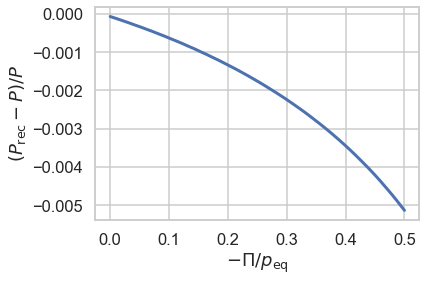

In [18]:
#CE total pressure reconstruction accuracy
per_diff = []
for R_Pi_inv in R_Pi_grid:
    bulk_Pi_sw = -R_Pi_inv * p_sw 
    P0_sw = p_sw + bulk_Pi_sw
    #test reconstruction of total presure in CE
    P0_test_CE = calc_tot_isotropic_pressure_CE(beta_sw, bulk_Pi_sw, beta_Pi0, F0)
    p_diff = (P0_test_CE - P0_sw) / P0_sw
    per_diff.append(p_diff)
    
plt.plot(R_Pi_grid, per_diff, lw=3)
plt.ylabel(r'$(P_{\rm rec} - P)/P$')
plt.xlabel(r'$-\Pi / p_{\rm eq}$')
plt.tight_layout(True)
plt.savefig('plots/P_reconst_err_CE.png', dpi=500)